# Multiview Training
This code will produce a model that can take two views of the cow and hopfully achieve a better predication. 

In [1]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras import layers
import keras
import tensorflow as tf
import numpy as np
import os
from PIL import Image
from tqdm.notebook import tqdm
import keract
from matplotlib import pyplot as plt
import cv2
from generator import Generator
from importlib import reload

In [227]:
# fix some memory expansion issues by allowing growth on the gpu
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [228]:
DATABASE_LOCATION = 'E:/cattle_data'
INPUT_PATH = DATABASE_LOCATION+'/training'
DATASET = 'two_view_training.json'

## Load Data

In [229]:
# load training data
import pandas as pd
df = pd.read_json(os.path.join(INPUT_PATH, DATASET))
print(len(df))
df.head()

27901


,date,weight,side_id,end_id,side_path,end_path
0,2021-11-30,565,126454,126452,E:/cattle_data/training/two_views/1_0_126454_s...,E:/cattle_data/training/two_views/1_0_126452_e...
1,2021-11-30,565,126463,126446,E:/cattle_data/training/two_views/1_1_126463_s...,E:/cattle_data/training/two_views/1_1_126446_e...
2,2021-11-30,565,126453,126451,E:/cattle_data/training/two_views/1_2_126453_s...,E:/cattle_data/training/two_views/1_2_126451_e...
3,2021-11-30,565,126460,126461,E:/cattle_data/training/two_views/1_3_126460_s...,E:/cattle_data/training/two_views/1_3_126461_e...
4,2021-11-30,565,126449,126447,E:/cattle_data/training/two_views/1_4_126449_s...,E:/cattle_data/training/two_views/1_4_126447_e...


### Prep Data

In [230]:
# trim the data to a constrained weight range 
df_trim = df[(df.weight > 400) & (df.weight < 1450)]

In [231]:
# reserve recent data for evaluation
# last reserve from 2022-01-22
cuttoff = '2022-02-13'
eval_df = df_trim[df_trim.date > cuttoff].copy()
training_df = df_trim[df_trim.date < cuttoff].copy()

In [232]:
len(eval_df)

6202

In [233]:
# split the training data into training and testing
def train_test_split(d, frac=0.2):
    test = d.sample(frac=frac, axis=0)
    train = d.drop(index=test.index).sample(frac=1, axis=0)
    return train, test

In [234]:
train_df, test_df = train_test_split(training_df)

In [258]:
Generator = reload(generator).Generator

In [259]:
train_gen = Generator(train_df, X_col=['side_path', 'end_path'], y_col='weight', batch_size=64, model_input_shape=(224,224), color='rgb', shuffle=True)
val_gen = Generator(test_df, X_col=['side_path', 'end_path'], y_col='weight', batch_size=64, model_input_shape=(224,224), color='rgb', shuffle=True)

## Create Two View Model

In [262]:
# load the model pretrained on single images
side_model = keras.models.load_model(DATABASE_LOCATION+"/models/exceptionet_best_model")
end_model = keras.models.load_model(DATABASE_LOCATION+"/models/exceptionet_best_model")

In [263]:
side_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 100)               204900    
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 101       
                                                           

In [264]:
# unfreeze layers
for layer in side_model.layers:
    layer.trainable = True
for layer in end_model.layers:
    layer.trainable = True

In [265]:
# take off last layer
side_out = side_model.layers[-2].output
end_out = end_model.layers[-2].output

side_model = tf.keras.Model(inputs = side_model.input, outputs = side_out)
end_model = tf.keras.Model(inputs = end_model.input, outputs = end_out)

In [266]:
# create new inputs for side and end
side_input_layer = tf.keras.Input(shape=(224, 224, 3))
end_input_layer = tf.keras.Input(shape=(224, 224, 3))

side = side_model(side_input_layer, training=True)
end = end_model(end_input_layer, training=True)

# combine side and end features 
x = tf.keras.layers.concatenate([side, end])
#x = tf.keras.layers.Activation('relu')(x)

bias_init = tf.keras.initializers.Constant(700.0)#df.weight.mean())
outputs = tf.keras.layers.Dense(1, bias_initializer=bias_init)(x) # reduce to one node for weight prediction

model_xcept = tf.keras.Model(inputs = [side_input_layer, end_input_layer], outputs = outputs)

In [267]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model_xcept.compile(
    loss= "mean_squared_error" , 
    optimizer=opt, 
    metrics=["mean_squared_error"])

In [268]:
model_xcept.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_6 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 model_6 (Functional)           (None, 100)          21066380    ['input_5[0][0]']                
                                                                                            

## Train the Model

In [269]:
hist = model_xcept.fit(
        train_gen,
        steps_per_epoch=50,
        epochs=100,
        validation_data=val_gen,
        validation_steps=15,
        #callbacks=[tensorboard_callback]
        verbose=1,
        )

Epoch 1/100
50/50 [==============================] - 146s 3s/step - loss: 54830.4102 - mean_squared_error: 54830.4102 - val_loss: 39055.6094 - val_mean_squared_error: 39055.6094
Epoch 2/100
50/50 [==============================] - 117s 2s/step - loss: 41942.5508 - mean_squared_error: 41942.5508 - val_loss: 36398.0820 - val_mean_squared_error: 36398.0820
Epoch 3/100
50/50 [==============================] - 112s 2s/step - loss: 35636.5820 - mean_squared_error: 35636.5820 - val_loss: 34218.2734 - val_mean_squared_error: 34218.2734
Epoch 4/100
50/50 [==============================] - 108s 2s/step - loss: 33348.8906 - mean_squared_error: 33348.8906 - val_loss: 43775.4766 - val_mean_squared_error: 43775.4766
Epoch 5/100
50/50 [==============================] - 105s 2s/step - loss: 34175.7891 - mean_squared_error: 34175.7891 - val_loss: 36566.9805 - val_mean_squared_error: 36566.9805
Epoch 6/100
50/50 [==============================] - 107s 2s/step - loss: 31874.5625 - mean_squared_error: 318

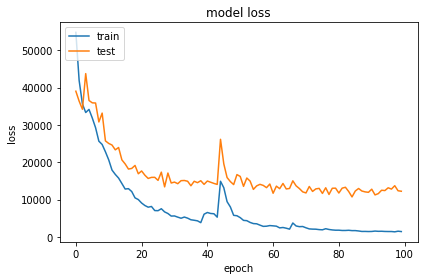

In [270]:
history = hist
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [273]:
hist = model_xcept.fit(
        train_gen,
        steps_per_epoch=50,
        epochs=20,
        validation_data=val_gen,
        validation_steps=15,
        #callbacks=[tensorboard_callback]
        verbose=1,
        )

Epoch 1/20
50/50 [==============================] - 111s 2s/step - loss: 3215.0122 - mean_squared_error: 3215.0122 - val_loss: 12320.8730 - val_mean_squared_error: 12320.8730
Epoch 2/20
50/50 [==============================] - 99s 2s/step - loss: 2533.2051 - mean_squared_error: 2533.2051 - val_loss: 12634.8467 - val_mean_squared_error: 12634.8467
Epoch 3/20
50/50 [==============================] - 100s 2s/step - loss: 1904.0093 - mean_squared_error: 1904.0093 - val_loss: 12607.6973 - val_mean_squared_error: 12607.6973
Epoch 4/20
50/50 [==============================] - 99s 2s/step - loss: 1887.0127 - mean_squared_error: 1887.0127 - val_loss: 11626.3213 - val_mean_squared_error: 11626.3213
Epoch 5/20
50/50 [==============================] - 100s 2s/step - loss: 1723.8599 - mean_squared_error: 1723.8599 - val_loss: 11451.2246 - val_mean_squared_error: 11451.2246
Epoch 6/20
50/50 [==============================] - 99s 2s/step - loss: 1543.2599 - mean_squared_error: 1543.2599 - val_loss: 1

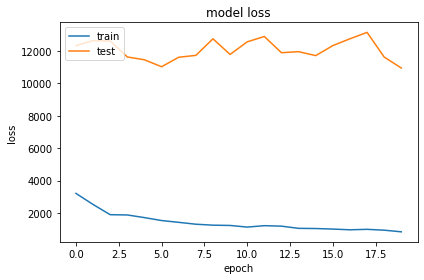

In [274]:
history = hist
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [226]:
img_path='E:/cattle_data/img/ponoka/im_22053.png'
img = image.load_img(img_path, target_size=(224, 224), color_mode='rgb')
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = x/255.
model_xcept.predict([x, x])

array([[1100.7622]], dtype=float32)

In [334]:
model_xcept.save(DATABASE_LOCATION+"/models/two_view_model")

INFO:tensorflow:Assets written to: E:/cattle_data/models/two_view_model\assets


C:\Users\derek\anaconda3\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
C:\Users\derek\anaconda3\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


In [220]:
model_xcept = tf.keras.models.load_model(DATABASE_LOCATION+"/models/two_view_model")

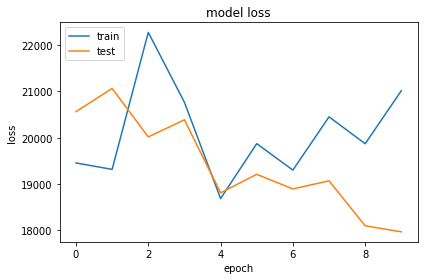

In [99]:
history = hist
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Evaluate

In [332]:
from matplotlib.patches import Patch

def display_activation(model, image_frame):
    
    """
    Displays heatmaps of each layer overlaid onto the original image.
    :param model: Keras compiled model
    :param image_frame: The pandas frame from which to get the X and y data to feed the model.
    """
    
    img_path = image_frame.path
    if os.path.exists(img_path):
        img = image.load_img(img_path, target_size=(224, 224), color_mode=color)
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = x/255.

        activations = keract.get_activations(model, x, layer_names=None, nodes_to_evaluate=None, output_format='simple', nested=False, auto_compile=True)
        #keract.display_activations(activations, cmap=None, save=False, directory='.', data_format='channels_last', fig_size=(24, 24), reshape_1d_layers=False)
        keract.display_heatmaps(activations, x, save=False)
        #return heatmap, output
        
        
# Add padding to image
# Function taken from:
# https://note.nkmk.me/en/python-pillow-add-margin-expand-canvas/
def expand2square(pil_img, background_color):
    width, height = pil_img.size
    if width == height:
        return pil_img
    elif width > height:
        result = Image.new(pil_img.mode, (width, width), background_color)
        result.paste(pil_img, (0, (width - height) // 2))
        return result
    else:
        result = Image.new(pil_img.mode, (height, height), background_color)
        result.paste(pil_img, ((height - width) // 2, 0))
        return result
        
def load_img(img_path, target_size, color_mode):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=None, color_mode=color_mode)
    img = expand2square(img, (0))
    img = tf.image.resize(
            img,
            size=target_size,
            preserve_aspect_ratio=True,
            antialias=False)
    x = tf.keras.preprocessing.image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = x/255.
    return x

        
def test_on_image(models, image_frame, model_labels = [], display_each=True, display_width = 3):
    
    """
    Run model on set of images in the given pandas frame. The image frame must include a ['path'] column to the image as well as a 
    ['weight'] column with the true values for the image. 
    
    :param model: Keras compiled model
    :param image_frame: The pandas frame from which to get the X and y data to feed through the model.
    :param display_each: (optional) If this is True, each image in the frame will be displayed inline along with its given truth
    and prediction.
    :param display_activation: (optional) If this is True, an activation map will be overlayed onto the image to show 
    "where the network is looking" for the given image. In this case, 'display_each' should also be set to True.
    :return: Prints the average error and accuracy of the given test set. Returns the accuracy score. 
    """
    p_times = 1
    p_m = 0
    
    # handle model_labels length mismatch
    if len(model_labels) == 0:
        for i in range(len(models)):
            model_labels.append('Model '+str(i))
            
    elif len(model_labels) != len(models):
        raise ValueError("Number of model labels does not match number of models")
    
    # display a loading bar
    if not display_each:
        pbar = tqdm(total=len(image_frame))
    
    else:
        display_width = min(display_width, len(image_frame))
        fig, ax = plt.subplots(max(len(image_frame)//display_width, 1), min(display_width, len(image_frame)), figsize=(7*display_width, 4*len(image_frame)//display_width))
        fig.tight_layout(h_pad=25)
        #plt.rcParams["figure.figsize"] = [12.2, 5.5]
        plt.rcParams["figure.autolayout"] = True
    
    error = np.zeros(len(models))
    
    non_existent = 0
    
    # test on all the models and all the images
    for i in range(len(image_frame)):
        
        img_side_path = image_frame.iloc[i].side_path
        img_end_path = image_frame.iloc[i].end_path
            
        if os.path.exists(img_side_path):
            
            x0 = load_img(img_side_path, target_size=(224,224), color_mode='rgb')
            x1 = load_img(img_end_path, target_size=(224,224), color_mode='rgb')
            pred = np.zeros((len(models), p_times))
            
            # get predictions from each model to be tested
            for j, model in enumerate(models):

                # set the color mode based on the number of color channels in the model
                if model.input_shape[0][3] == 1:
                    x_0 = x0[:, :, :, 1]
                    x_1 = x1[:, :, :, 1]
                else:
                    x_0 = x0
                    x_1 = x1
                
                for n in range(p_times):
                    pred[j, n] = model.predict([x_0, x_1])[0][0]
            
            # get the mean and error rate for predictions
            p_m = pred.std(axis=1)*2.576 # 99% confidance interval
            pred = pred.mean(axis=1)
            
            # display the results 
            if display_each:
                barwidth = 32
                font_size = 12
                gw, gh = 448, 224

                if type(ax) == np.ndarray:
                    if len(ax.shape) == 1:
                        a = ax[i]
                    else:
                        a = ax[i//3][i%3]
                else:
                    a = ax
                
                
                ax_ = a.twinx()
                ax_1 = ax_.twinx()
                
                im = a.imshow(np.concatenate((np.squeeze(x_0), np.squeeze(x_1)), axis=1), extent=[0, gw, 0, gh])
                horiz = np.array(range(barwidth, len(pred)*barwidth+barwidth, barwidth))
                acc = (1 - np.abs(np.full(len(pred), image_frame.iloc[i].weight) - np.array(pred))/np.full(len(pred), image_frame.iloc[i].weight))*100

                ax_.bar(x = horiz, tick_label = model_labels, width=barwidth, linewidth=2, edgecolor='black', height = acc, alpha=0.5)
                ax_1.bar(x = gw - np.flip(horiz, axis=0), tick_label = [label+'_' for label in np.flip(model_labels, axis=0)], width=barwidth, linewidth=2, color='orange', edgecolor='black', height = pred, alpha = 0.5)
                ax_1.bar(x = gw - barwidth*(len(pred)+1), width=barwidth*(len(pred)+1), linewidth=2, align='edge', color='red', edgecolor='white', height=image_frame.iloc[i].weight, alpha=0.2)
                
                # print accuracy values
                for k, val in enumerate(acc):
                    ax_.text(horiz[k] - 4, val/2 - 10, '{:.1f}%'.format(val), color = 'white', fontweight = 'bold', rotation = 'vertical', size=font_size)
                    
                # print weight values
                for k, (val, val1) in enumerate(zip(pred, p_m)):
                    ax_1.text(gw - horiz[k] - 4, val/2 - 250, '{:.1f}lb +-{:.1f}'.format(val, val1), color = 'white', fontweight = 'normal', rotation = 'vertical', size=font_size)
                    
                #ax_.set_aspect('equal', adjustable=None, anchor=None, share=False)
                legend_elements = [Patch(facecolor='red', edgecolor='black',
                             label='True Weight'),
                       Patch(facecolor='orange', edgecolor='black',
                             label='Predicted Weight'),
                       Patch(facecolor='C0', edgecolor='black',
                             label='Accuracy')]

                #ax_.set_ylabel('Accuracy')
                ax_.set_xticks(np.concatenate([horiz, gw-np.flip(horiz, axis=0)], axis=0), labels=np.concatenate([model_labels, model_labels], axis=0))
                ax_1.set_ylabel('Predicted Weight (lbs)') 
                ax_1.set_ylim(0, 1500)
                ax_.set_ylim(0, 120)
                ax_.set_yticks(range(0, 125, 25))
                a.set_yticks([])
                #a.set_ylabel('Percent Accuracy')
                a.tick_params(axis='x', labelrotation= 70)
                a.set_title('Actual Weight: {} lbs'.format(image_frame.iloc[i].weight))
                #print('Predicted: {} lbs, Actual: {} lbs'.format(pred, image_frame.iloc[i].weight))

            # accumulate the error over the set of inputs
            error += abs(image_frame.iloc[i].weight - pred) / image_frame.iloc[i].weight 
        else:
            non_existent += 1
        
        if not display_each:
            pbar.update(1)
    
    if display_each:
        fig.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(0., 0.92, 0.02, 0.102),
                          ncol=1, borderaxespad=0.)
        fig.suptitle('Model Comparison', fontsize=30, verticalalignment='top')
        #plt.xticks(rotation='vertical')
        plt.show()

    # calculate the error and accuracy as an average for the set
    #print('{} average Error Rate: {:.2f}%'.format(model_labels[j], error[j]*100 / (len(image_frame) - non_existent)))
    acc = (1-error / (len(image_frame) - non_existent))*100
    
    for i, label in enumerate(model_labels):
        print('{} average accuracy: {:.2f}%'.format(label, acc[i]))    
        
    return acc


In [284]:
n = np.array([[5,5.5, 6],[12,6,24]])

In [296]:
n.mean(axis=1)

array([ 5.5, 14. ])

In [327]:
X = eval_df.sample(n=6)

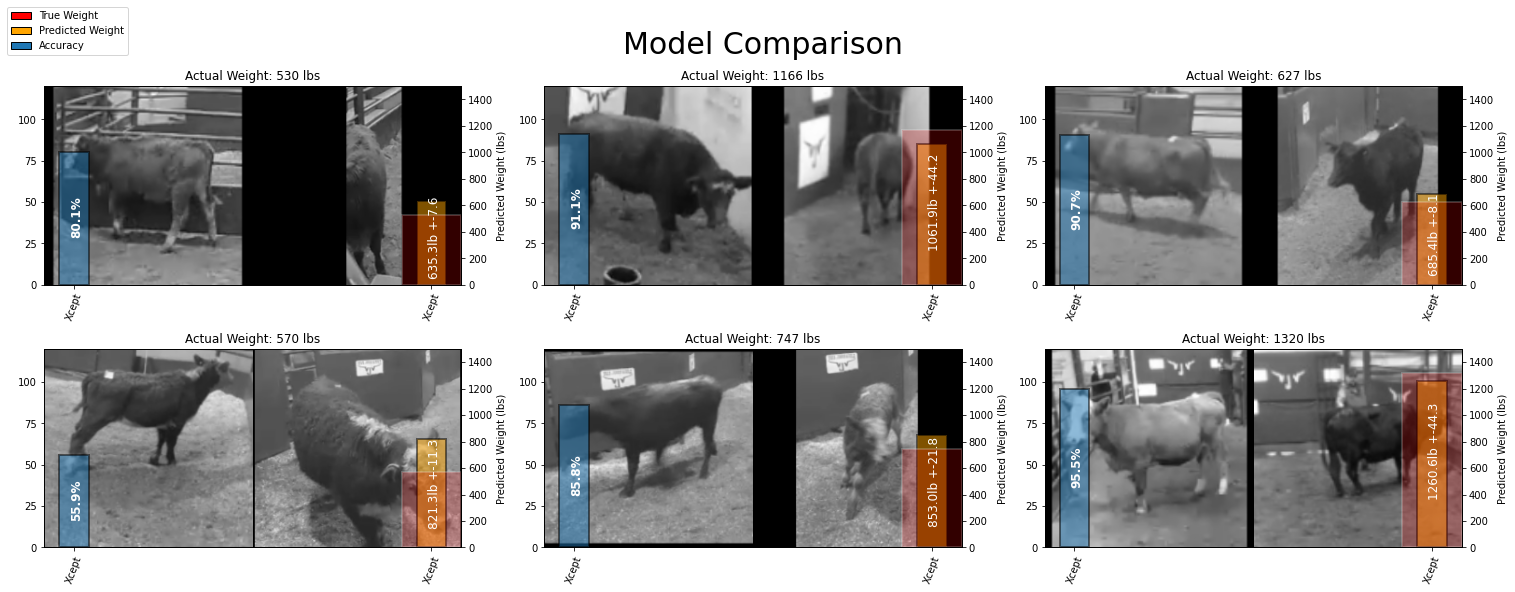

Xcept average accuracy: 83.19%


In [326]:
test_on_image([model_xcept], X, model_labels=['Xcept'], display_each=True);

In [333]:
result = test_on_image([model_xcept], eval_df, model_labels=['Xcept'], display_each=False)

  0%|          | 0/6202 [00:00<?, ?it/s]

Xcept average accuracy: 84.41%
